## DYLEMAT STUDENTA - WYTRAWNE WINO CZY TANIE I OBIAD?
### Wyznaczanie jakości wina na podstawie parametrów cieczy. | Aplikacja dla urzędu kontrolującego winiarnie



Celem projektu jest porównanie w zależności od problemu(regresja/klasyfikacja) różnego rodzaju modeli wraz z różnego rodzaju hiperparametrami.

● https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
 
    
Team members:
- Monika Janicka
- Tomasz Kamiński
- Artur Kłapciński
- Elżbieta Kondracka-Zwolska

1. [BIBLIOTEKI](#BIBLIOTEKI)
2. [DANE_&_WYKRESY](#DANE_&_WYKRESY)
3. [PREPROCESSING](#PREPROCESSING)
4. [MODELE](#MODELE)
4.1 [MODEL1_REGRESJA_LINEARNA](##MODEL1_REGRESJA_LINIOWA)
4.2 [MODEL2_REGRESJA_LOGISTYCZNA](##MODEL2_REGRESJA_LOGISTYCZNA)
4.3 [MODEL3_DECISION_TREE](##MODEL3_DECISION_TREE)
4.4 [MODEL4_RANDOM_FOREST](##MODEL4_RANDOM_FOREST)
4.5 [MODEL5_GBOOST](##MODEL5_XGBOOST)
5. [PORÓWNANIE_MODELI](#PORÓWNANIE_MODELI)

<a id='BIBLIOTEKI'></a>
# 1. BIBLIOTEKI

In [4]:
# Libraries for exploring, handling and visualizing data
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import math
import sklearn   
import sklearn.datasets as datasets
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder    # Sklearn's preprocessing library  
from sklearn.linear_model import LinearRegression   
from sklearn import preprocessing
import sklearn.metrics
import sklearn.model_selection
import sklearn.tree as tree                                        # DRZEWO DECYZYJNE
from scipy import stats
from sklearn.model_selection import cross_validate, GridSearchCV ,RandomizedSearchCV      # DO WALIDACJI SKROŚNEJ(KRZYŻOWEJ)
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV   # Importing train and test data split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree    # DRZEWO DECYZYJNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
# Sklearn's metrics to evaluate our models
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, roc_auc_score,classification_report, mean_squared_error, plot_roc_curve
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier # Classifiers
from sklearn.linear_model import LogisticRegression        # estymator klasyfikacji=klasyfikator
from mlxtend import plotting

# Setting theme style and color palette to seaborn 
sns.set_theme(context = 'notebook', style='darkgrid',palette='muted')

from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, SVR
from IPython.display import Image
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import fetch_california_housing 

import statsmodels.api as sm 
from sklearn.decomposition import PCA # analiza głównych składowych - w celu redukcji wymiarowości danych
from scipy import signal
import scipy 
from imblearn.over_sampling import SMOTE

<a id='DANE'></a>
# 2. DANE_&_WYKRESY

In [5]:
df = pd.read_csv("df_rm_z_duplikatami.csv") 
df # display the data frame
df.head(11)

volatile acidity  citric acid  total sulfur dioxide  density  sulphates  \
0               0.70         0.00                  34.0   0.9978       0.56   
1               0.88         0.00                  67.0   0.9968       0.68   
2               0.76         0.04                  54.0   0.9970       0.65   
3               0.28         0.56                  60.0   0.9980       0.58   
4               0.70         0.00                  34.0   0.9978       0.56   
5               0.66         0.00                  40.0   0.9978       0.56   
6               0.60         0.06                  59.0   0.9964       0.46   
7               0.65         0.00                  21.0   0.9946       0.47   
8               0.58         0.02                  18.0   0.9968       0.57   
9               0.50         0.36                 102.0   0.9978       0.80   
10              0.58         0.08                  65.0   0.9959       0.54   

    alcohol  quality  
0       9.4        0  
1       9.8        0  
2       9.8        0  
3       9.8        0  
4       9.4        0  
5       9.4        0  
6       9.4        0  
7      10.0        1  
8       9.5        1  
9      10.5        0  
10      9.2        0

#### Pairplot

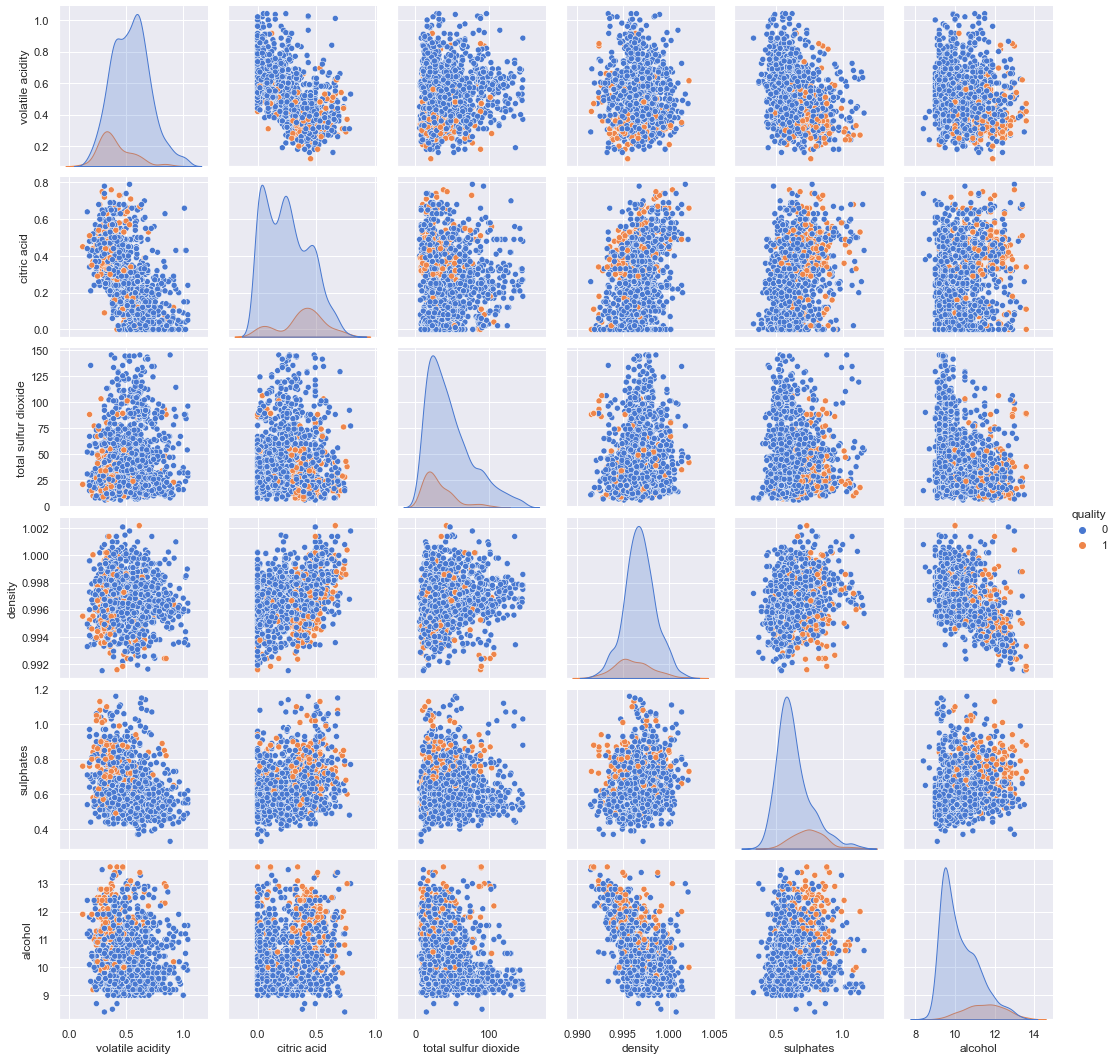

In [7]:
sns.pairplot(df, hue="quality")

#### Boxploty i barploty

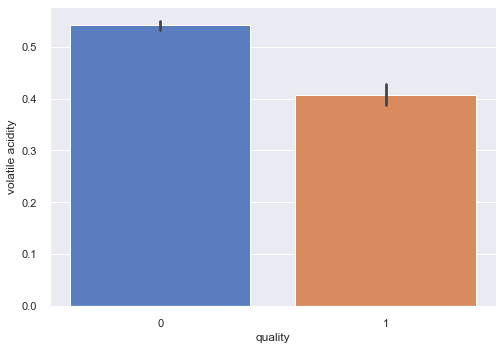

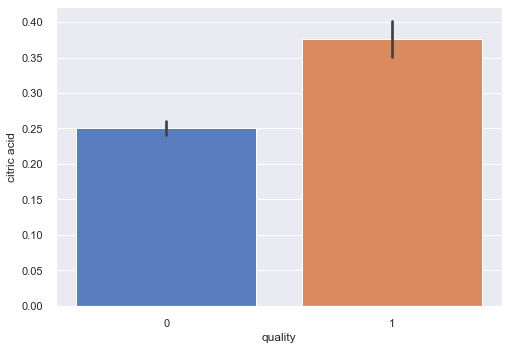

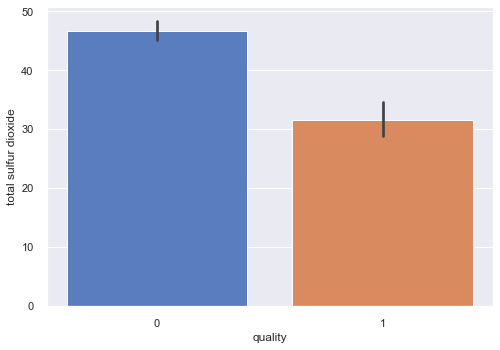

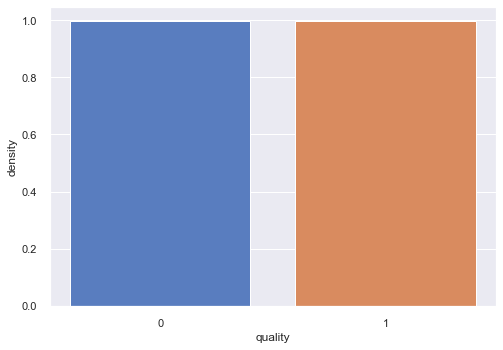

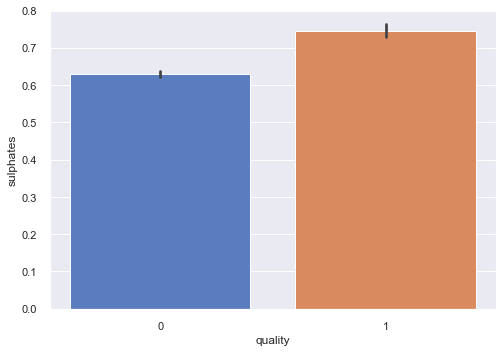

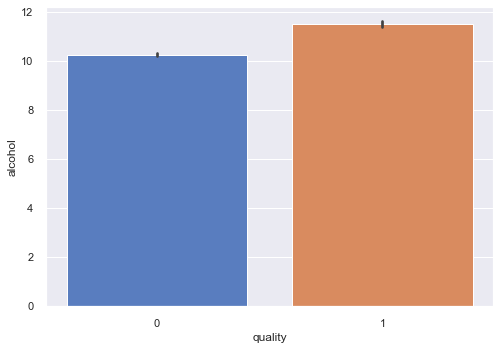

In [4]:
for i in df.columns[:-1]:
    plt.figure()
    sns.barplot(x=df.quality, y=df[i])
    plt.plot()

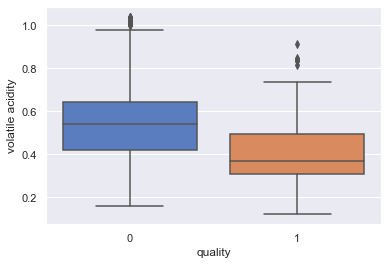

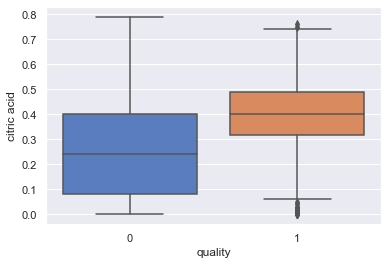

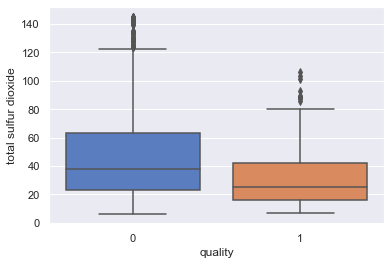

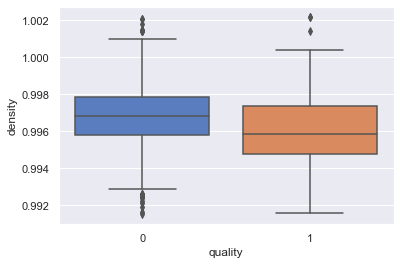

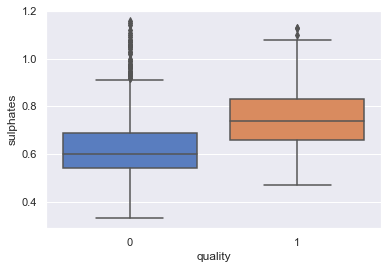

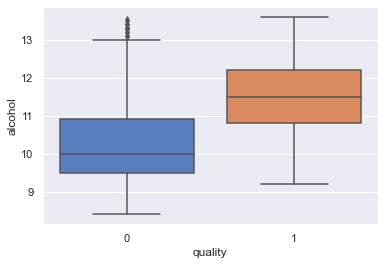

In [6]:
for i in df.columns[:-1]:
    plt.figure()
    sns.boxplot(x=df.quality, y=df[i])
    plt.plot()

#### Histogramy

In [1]:
# funkcja zwracająca cechy numeryczne
def get_quant_features(dataframe):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats]
# funkcja rysująca histogramy dla numerycznych cechy
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(16,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

C:\Users\tk\AppData\Local\Temp\ipykernel_148\1556525642.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feats = dataframe.select_dtypes([np.number, np.bool]).columns


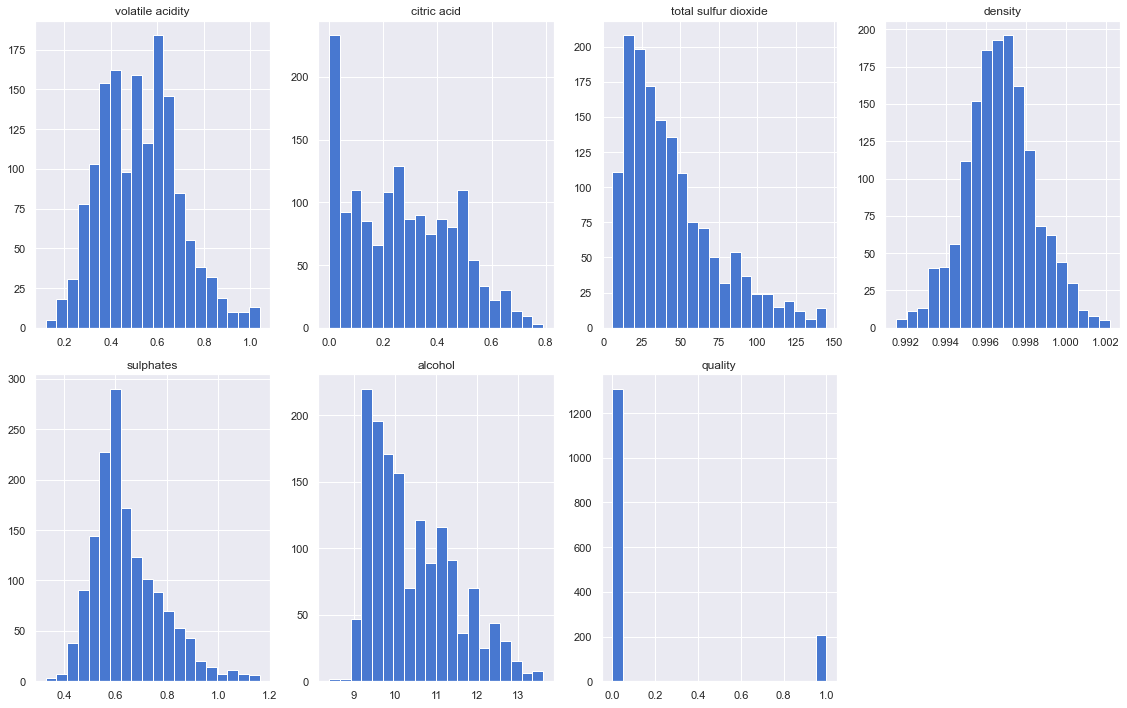

In [6]:
feats = get_quant_features(df)
draw_histograms(df, feats, 2, 4) # dwa wiersze i cztery kolumny

<a id='PREPROCESSING'></a>
# 3. PREPROCESSING

In [6]:
X = df.drop("quality", axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = df.quality, random_state=42)
print("The shape of X_train is:",X_train.shape)
print("The shape of X_test is:",X_test.shape)
print("The shape of y_train is:",y_train.shape)
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (1212, 6)
The shape of X_test is: (304, 6)
The shape of y_train is: (1212,)
The shape of y_test is: (304,)


In [8]:
X_standarized=pd.DataFrame()
for column in X.iloc[:].columns:
    X_standarized[column] = X[column].astype(float)

X_standarized.loc[:] = preprocessing.StandardScaler().fit_transform(X_standarized.loc[:])
X_standarized

volatile acidity  citric acid  total sulfur dioxide   density  \
0             1.053127    -1.388225             -0.353710  0.607771   
1             2.121345    -1.388225              0.745997  0.036521   
2             1.409200    -1.180507              0.312780  0.150771   
3            -1.439381     1.519830              0.512726  0.722021   
4             1.053127    -1.388225             -0.353710  0.607771   
...                ...          ...                   ...       ...   
1511          0.459673    -0.972789             -0.020465 -1.048854   
1512          0.162946    -0.868930              0.212806 -0.923179   
1513         -0.074436    -0.713141             -0.153763 -0.569004   
1514          0.726727    -0.765070             -0.020465 -0.723242   
1515         -1.261345     1.052464             -0.087114 -0.711817   

      sulphates   alcohol  
0     -0.641028 -0.986165  
1      0.253402 -0.598350  
2      0.029795 -0.598350  
3     -0.491957 -0.598350  
4     -0.641028 -0.986165  
...         ...       ...  
1511  -0.491957  0.080326  
1512   0.849690  0.759002  
1513   0.775154  0.565095  
1514   0.477010 -0.210535  
1515   0.104331  0.565095  

[1516 rows x 6 columns]

Text(0.5, 1.0, 'Współrzędne równoległe 6 cech')

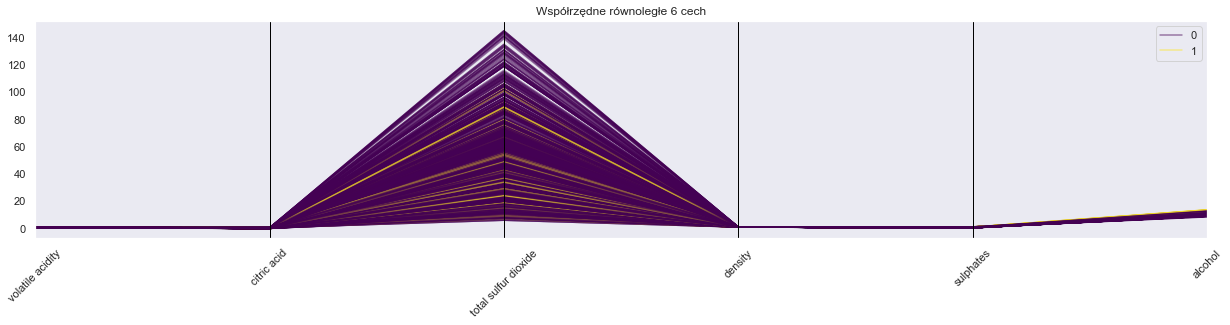

In [12]:
# Wykres współrzędnych równoległych Dla danych wielowymiarowych
from pandas.plotting import ( parallel_coordinates,) 
fig, ax = plt.subplots (figsize=(21, 4))
new_df = X.copy() 
new_df["target"] = y
parallel_coordinates(new_df, "target", ax=ax,colormap="viridis", alpha=0.5,)
ax.set_xticklabels ( ax.get_xticklabels(), rotation=45)

ax.set_title("Współrzędne równoległe 6 cech")

Text(0.5, 1.0, 'Wykres RadViz 8 cech')

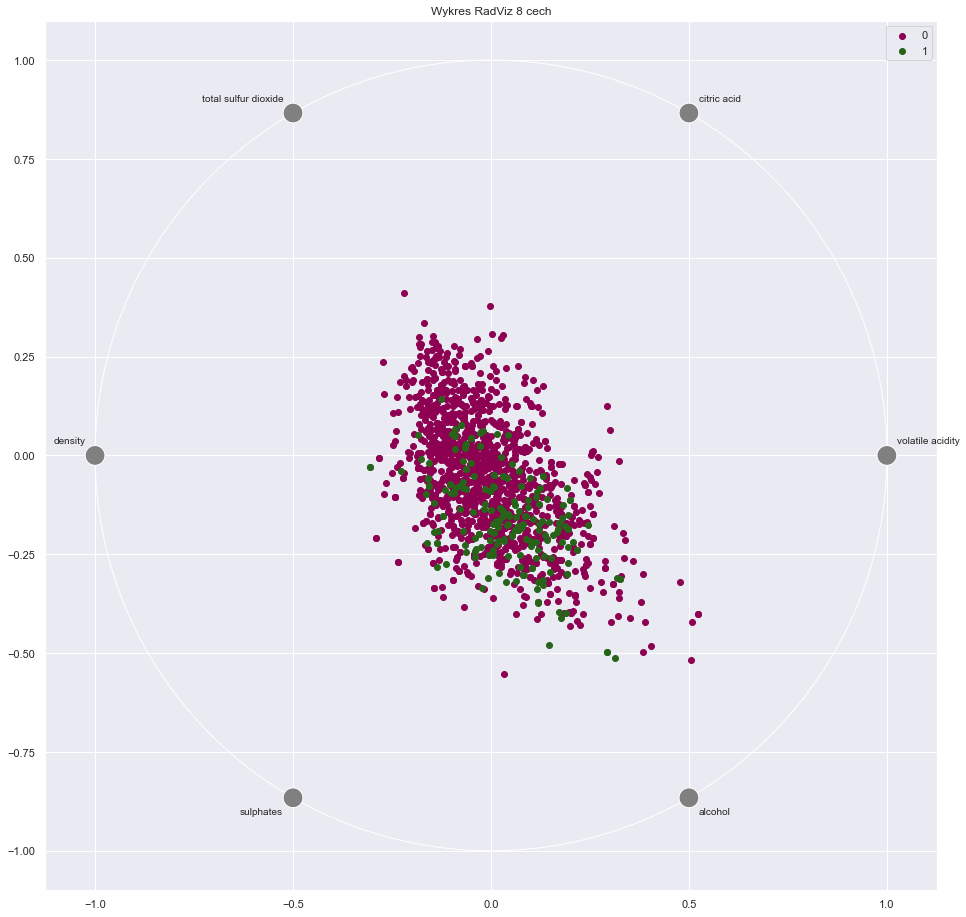

In [13]:
# Wykres ma postać koła w którego wnętrzu znajdują się punkty reprezentujące próbki danych a na obrzeżach cechy. Wartości są znormalizowane. Każdy punkt jest połączony za pomocą sprężyny z cechami do których jest przyciągany. 
# Jest to jeden ze sposobów wizualizowanie odrębności cech
from pandas.plotting import radviz
fig, ax = plt.subplots (figsize=(16, 16))
new_df = X.copy() 
new_df ["target"] = y
radviz(new_df, "target", ax=ax, colormap="PiYG")
ax.set_title("Wykres RadViz 8 cech") 

<a id='MODELE'></a>
# 4. MODELE

<a id='MODEL1_REGRESJA_LINEARNA'></a>
## 4.1. MODEL1_REGRESJA_LINIOWA

<a id='MODEL2_REGRESJA_LOGISTYCZNA'></a>
## 4.2. MODEL2_REGRESJA_LOGISTYCZNA

<a id='MODEL3_DECISION_TREE'></a>
## 4.3. MODEL3_DECISION_TREE

In [9]:
#Create an object (model)
dt = DecisionTreeClassifier(
random_state=42, 
max_depth=8,
class_weight=None,
criterion='gini', 
max_features=None, 
max_leaf_nodes=None,
min_impurity_decrease=0.0, 
min_samples_leaf=2, 
min_weight_fraction_leaf=0.0,  
splitter='best')
dt.fit(X_train, y_train) 

dt.score (X_test, y_test)

0.8848684210526315

In [10]:
dt.predict_proba (X.iloc[[0]]) 

array([[1., 0.]])

In [12]:
# Walidacja
cv_results = cross_val_score(dt,X, y,cv=5)  #ilokrotność walidacji cv(razy: trening na 4, testowanie na jednej | dzięki wielu podziałom można zobczyć jak radzi sobie z danymi
print(f'Scores: {np.round(cv_results,3)}')

Scores: [0.882 0.769 0.875 0.825 0.835]


In [15]:
print(f'Scores mean: {np.round(np.mean(cv_results),3)}') #liczę średnią ze scorów z kroswalidacji, wynik zbliżony z wynikiem score

Scores mean: 0.837


In [16]:
# 5 sprawdzamy dokładność, w regresji było accuracy, tutaj score
dt.score( X_test,y_test)   # wartość r2, kroswalidacja robi pięciokrotne taka czynność na 4 treningowych | SCORE Z DANYCH I TARGETU , MODEL JEST FITOWANY DO TYCH DANYCH
#powinno być powyżej 0,9, score jest właściwy dla danych zbalansowanych

0.8848684210526315

In [16]:
# Poniżej przedstawiony jest kod wizualizujący ważności cech Giniego (dzięki nim można zmniejszyć błąd modelu):

for col, val in sorted(zip (X.columns, dt.feature_importances_),
key=lambda x: x[1], reverse=True,
)[:5]:
    print(f" {col:10} {val: 10.3f}") 

 alcohol         0.590
 sulphates       0.221
 volatile acidity      0.096
 total sulfur dioxide      0.071
 density         0.021


c:\Users\tk\anaconda3\envs\my_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


[Text(0.5, 1.0, 'Ważność 6 cech (drzewo decyzyjne)'),
 Text(0.5, 0, 'Względna ważność')]

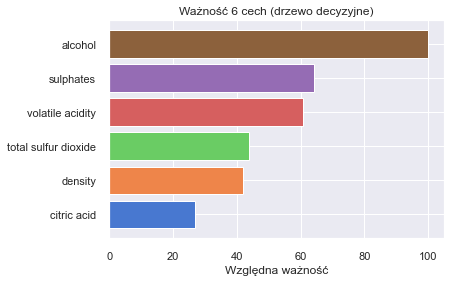

In [17]:
# Wykres ważności cech w odniesieniu do największej bezwzględnej wartości współczynnika regresji. Użyta do tej funkcja wizualizuj sama argument relative= True który powoduje że największej wartość jest przypisywana liczba 
# 100 lub minus 100 a pozostałem wartością proporcjonalnie mniejsze liczby. 
from yellowbrick.model_selection import FeatureImportances
fig, ax = plt.subplots (figsize=(6, 4))
fi_viz = FeatureImportances (dt)
fi_viz.fit(X, y)
fi_viz.ax.set(title="Ważność 6 cech (drzewo decyzyjne)", xlabel = "Względna ważność")

In [19]:
import graphviz.backend as be
from dtreeviz.trees import *
viz = dtreeviz(dt, X,y,target_name="cel",feature_names=X.columns, class_names=["słabe", "dobre"],scale=(0.8))
viz
# viz.save("decision_tree.svg")
#Wykres pokazuje informacje o funkcjonowaniu drzewa. Obraz drzewa z 100 histogramami zawierającymi cenne informacje

c:\Users\tk\anaconda3\envs\my_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [20]:
prediction_tr = dt.predict(X_train)
prediction_ts = dt.predict(X_test)
print(sklearn.metrics.classification_report(y_test, prediction_ts, target_names=["słabe", "dobre"]))

              precision    recall  f1-score   support

       słabe       0.92      0.95      0.93       262
       dobre       0.60      0.50      0.55        42

    accuracy                           0.88       304
   macro avg       0.76      0.72      0.74       304
weighted avg       0.88      0.88      0.88       304



In [21]:
print('accuracy train data is',accuracy_score(y_train,prediction_tr))
print('accuracy test data is',accuracy_score(y_test,prediction_ts))

accuracy train data is 0.9612211221122112
accuracy test data is 0.8848684210526315


In [22]:
print('recall train data is',recall_score(y_train,prediction_tr,average="macro"))
print('recall test data is',recall_score(y_test,prediction_ts,average="macro"))

recall train data is 0.8761719919832293
recall test data is 0.7232824427480916


In [24]:
# get confusion matrix
predictions = dt.predict(X_test)
matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
matrix

array([[248,  14],
       [ 21,  21]], dtype=int64)

In [25]:
# 9 Użyteczną metryką jest f1_score - średnia harmoniczna precyzji i czułości
# "micro" is preferrable, "macro" is good if there is no class imbalance
sklearn.metrics.f1_score(y_test, predictions, average="micro")  #micro -ustala w jaki sposób będziemy uśedniać po klasach

0.8848684210526315

c:\Users\tk\anaconda3\envs\my_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


[Text(0.5, 1.0, 'Tablica pomyłek klasyfikatora drzewa '),
 Text(0.5, 0, 'Klasa prognozowana'),
 Text(0, 0.5, 'Klasa rzeczywista')]

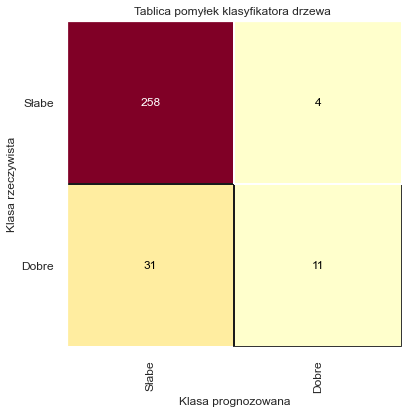

In [20]:
from yellowbrick.classifier import (ConfusionMatrix,)
mapping = {0: "Słabe", 1: "Dobre"} 
fig, ax = plt.subplots (figsize=(6, 6)) 
cm_viz = ConfusionMatrix( dt,classes=["Słabe", "Dobre"], label_encoder=mapping,) 
cm_viz.score (X_test, y_test) 
cm_viz.ax.set(title="Tablica pomyłek klasyfikatora drzewa ", xlabel="Klasa prognozowana", ylabel="Klasa rzeczywista")
# Ćwiartki lewa górna i prawa dolna zawierają poprawne wyniki klasyfikacji, a lewa dolna i prawa górna -błędne; ćwiartka lewa dolna zawiera wyniki fałszywie negatywne 
# a prawa górna - fałszywie pozytywne.  Centrum dobrego klasyfikatora są duże wartości prawdziwych wyników na przekątnej tabeli

c:\Users\tk\anaconda3\envs\my_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


[Text(0, 0.5, 'SŁABE'), Text(0, 1.5, 'DOBRE')]

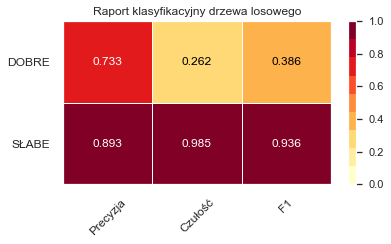

In [21]:
# Raport klasyfikacyjny prezentujący precyzję, czułośc, wskaźnik F1 dla wyników pozytywnych i negatywnych. 
# Im dany wskaźnik jest lepszy -bliższy jedności -tym komórka jest bardziej czerwona
from yellowbrick.classifier import (ClassificationReport,)
fig, ax = plt.subplots (figsize=(6, 3))
cm_viz = ClassificationReport( dt,classes=["SŁABE", "DOBRE"], label_encoder=mapping)

cm_viz.score (X_test, y_test) 
cm_viz.ax.set (title="Raport klasyfikacyjny drzewa losowego")
xlabels = ("Precyzja", "Czułość", "F1")
ax.set_xticks (np.arange(len(xlabels)) + 0.5) 
ax.set_xticklabels (xlabels, rotation=45)
ax.set_yticks (np.arange(len(cm_viz.classes)) + 0.5) 
ax.set_yticklabels (cm_viz.classes) 

0.5077767514532168


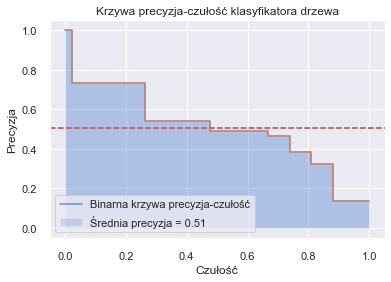

In [23]:
# Krzywa precyzja- czułość
# jeżeli klasy nie są zrównoważone wtedy na podstawie krzywej ROC  można wyciągnąć nadmiernie optymistyczne wnioski. 
# Dlatego stosowany jest inny sposób oceniania klasyfikatora polegające na wykreśleniu krzywej Precision- Recall curve. 
# Klasyfikacja to zrównoważony proces wyszukiwania potrzebnych danych (czułość) przy jednoczesnym ograniczeniu błędnych wyników (precyzja). 
# Zazwyczaj trzeba znaleźć kompromis między tymi pojęciami. Im większa czułość tym mniejsza precyzja i odwrotnie. Kod tworzący wykres precyzja czułość z krzywą

from yellowbrick.classifier import ( PrecisionRecallCurve,)
fig, ax = plt.subplots (figsize=(6, 4))
viz = PrecisionRecallCurve (DecisionTreeClassifier (max_depth=3))

viz. fit (X_train, y_train)
print(viz.score (X_test, y_test)) 
viz.ax.set(title="Krzywa precyzja-czułość klasyfikatora drzewa",xlabel="Czułość", ylabel="Precyzja") 
ax.legend (("Binarna krzywa precyzja-czułość","Średnia precyzja = {:0.2f}".format (viz.score(X_test,y_test))),frameon=True, loc="lower left") 

[Text(0.5, 1.0, 'Równowaga klas dla (:,) próbek'),
 Text(0, 0.5, 'Liczba próbek')]

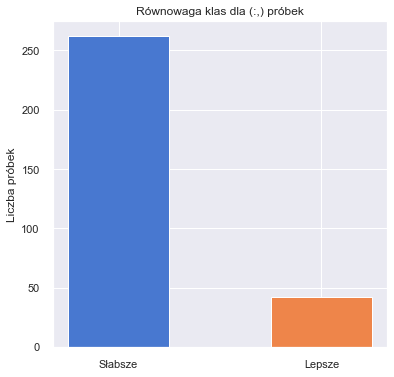

In [24]:
# Równowaga class

# Wykres ilustruje wielkość klas, jeżeli klasy różnią się wielkością wtedy dokładność nie jest odpowiednim wskaźnikiem jakości modelu.  
# Aby zachować właściwe proporcje między klasami danych należy przydzieleniu ich na zbiory treningowy i testowy stosować losowanie warstwowe (parametr stratify)
from yellowbrick.classifier import ClassBalance
fig, ax = plt.subplots (figsize=(6,6))

cb_viz=ClassBalance (labels =["Słabsze", "Lepsze"])
cb_viz.fit(y_test)

ax.set_xticks (np.arange(len(cb_viz.labels))) 
ax.set_xticklabels (cb_viz.labels) 
ax.set(title="Równowaga klas dla (:,) próbek".format(cb_viz.support_.sum()), ylabel="Liczba próbek")
# Na wykresie uzyskano nierównowagę klas

c:\Users\tk\anaconda3\envs\my_env\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


[Text(0.5, 1.0, 'Błąd prognozowania klas dla klasyfikatora drzewa losowego'),
 Text(0.5, 0, 'Klasa rzeczywista'),
 Text(0, 0.5, 'Klasa prognozowana')]

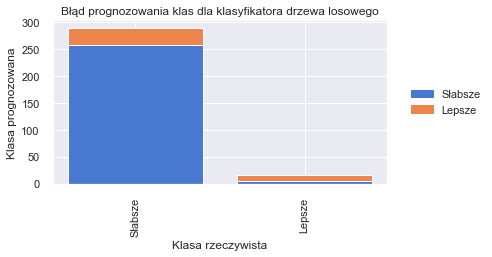

In [25]:
# Błąd prognozowania klas
# wykres błędu prognozowania klas ilustrujący tablicę pomyłek. 

from yellowbrick.classifier import (ClassPredictionError,)

fig, ax = plt.subplots (figsize=(6, 3)) 
cpe_viz = ClassPredictionError(dt, classes=["Słabsze", "Lepsze"])
cpe_viz.score (X_test, y_test)
ax.set_xticks (np.arange(len(cpe_viz.classes))) 
ax.set_xticklabels (cpe_viz.classes)
ax.set(title="Błąd prognozowania klas dla klasyfikatora drzewa losowego", xlabel="Klasa rzeczywista", ylabel="Klasa prognozowana")

c:\Users\tk\anaconda3\envs\my_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


[Text(0.5, 1.0, "Lokalna interpretacja klasy 'lepsze'")]

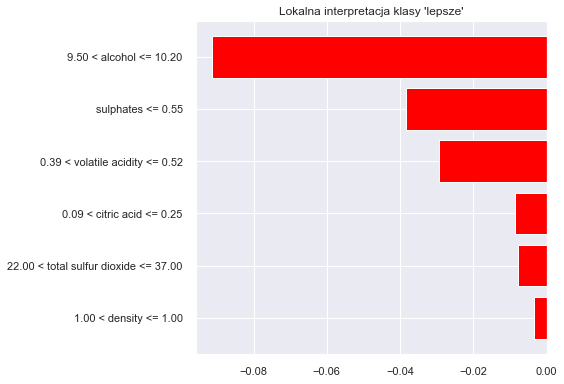

In [26]:
# Analiza LIME  pokazująca, jak poszczególne cechy próbki przesuwają wyniki prognozy w prawo (wybór lepszego gatunku) lub w lewo (słabego gatunku)
# Poniżej przedstawiony jest kod umożliwiający interpretację ostatniej próbki danych ze zbioru treningowego, dla której nasz model drzewa decyzyjnego prognozuje wybór lepszego gatunku:

from lime import lime_tabular 
explainer = lime_tabular. LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=["słabsze", "lepsze"])
exp = explainer.explain_instance( X_train.iloc[-1].values, dt.predict_proba)
# Danymi wejściowymi dla pakietu LIME nie może być struktura DataFrame. Zwróć uwagę, że jest ona zamieniana na tablicę numpy za pomocą atrybutu .values.
fig = exp.as_pyplot_figure() 
fig.tight_layout()
fig.gca().set (title="Lokalna interpretacja klasy '%s'" % exp.class_names [1])

In [31]:
ypred = dt.predict(X_test)
ypred
roc_auc_score(y_test, ypred)

0.7232824427480916

c:\Users\tk\anaconda3\envs\my_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


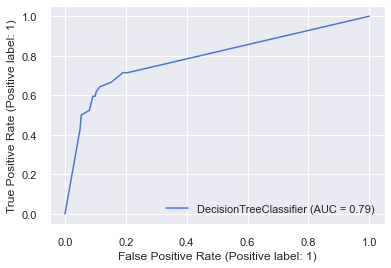

In [34]:
plot_roc_curve(dt, X_test, y_test)

<a id='MODEL4_RANDOM_FOREST'></a>
## 4.4. MODEL4_RANDOM_FOREST

<a id='MODEL5_XGBOOST'></a>
## 4.5. MODEL5_XGBOOST

<a id='PORÓWNANIE_MODELI'></a>
# 5. PORÓWNANIE_MODELI

In [ ]:
# zdefiniowanie walidacji
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# zdefiniowanie prostych modeli
LR_model = LogisticRegression()
DT_model = DecisionTreeClassifier(random_state=42)
RF_model = RandomForestClassifier(random_state=42)
XGB_model = XGBClassifier(eval_metric='error', random_state=42)



# dodanie modeli do listy, po której będziemy iterowali
models = [ LR_model, DT_model, RF_model, XGB_model]

In [ ]:
# ewaluacja modeli
for model in models:
    run_model(model, X_train, y_train, skf)

In [ ]:
# fit models
for model in models:
    model.fit(X_train, y_train)

In [ ]:
# wyniki predykcji
y_pred_LR_model = LR_model.predict(X_test)
y_pred_DT_model = DT_model.predict(X_test)
y_pred_RF_model = RF_model.predict(X_test)
y_pred_XGB_model = XGB_model.predict(X_test)

y_pred_LR_model,y_pred_DT_model,y_pred_RF_model,y_pred_XGB_model

In [ ]:
# sprawdzenie fbeta_score dla każdego modelu między wynikami predykcji
# a rzeczywistymi wartościami ze zbioru treningowego
fbeta_LR = fbeta_score(y_test, y_pred_LR_model, beta=0.5)
fbeta_DT = fbeta_score(y_test, y_pred_DT_model, beta=0.5)
fbeta_RF = fbeta_score(y_test, y_pred_RF_model, beta=0.5)
fbeta_XGB = fbeta_score(y_test, y_pred_XGB_model, beta=0.5)

results = [ fbeta_LR, fbeta_DT, fbeta_RF, fbeta_XGB]

In [ ]:
print("-----Wyniki f-beta na zbiorze testowym-----")
print("Logistic Regression f-beta: {:.4f}".format(fbeta_LR))
print("Decision Tree f-beta: {:.4f}".format(fbeta_DT))
print("RandomForest f-beta: {:.4f}".format(fbeta_RF))
print("XGBoost f-beta: {:.4f}".format(fbeta_XGB))

##### confusion matrix dla XGBoost - jeśli wyjdzie najlepszy wynik

In [ ]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_XGB_model)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()] #flatten() 'splaszcza' matryce

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Predicted', ylabel='Actual');